<a href="https://colab.research.google.com/github/ioiein/Advanced-ML/blob/main/Homework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

Часть I

Пусть событие $A$ - подсудимый виновен, событие $B$ - у человека редкая группа крови. Тогда из условия следует, что $P(B) = 0,01$, и $P(B|A) = 1$.
Прокурор утверждает, что "шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%", в своей фразе он оценил $P(B|\overline{A})$:
$$P(B|\overline{A}) = \frac{P(\overline{A}|B)*P(B)}{P(\overline{A})}$$
$$P(\overline{A}) = P(\overline{A}|B)*P(B) + P(\overline{A}|\overline{B})*P(\overline{B}) = (1 - 10^{-4})*0,01 + 1*0,99 = 0,999999$$
$P(B|\overline{A}) \approx 0,01$. Однако, он берет отрицание этого события, заявляя, что это вероятность виновности, но это $P(\overline{B}|\overline{A})$, которое означет вероятность обычной группы крови, при невиновности.

Адвокат же оценивает вероятность $P(A|B)$, которая дествительно равна $10^{-4}$. Однако адвокат утверждает, что "это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен", но он не прав, так как данный факт увеличивает вероятность виновности в 100 раз.

Пусть $A$ - это событие положительного теста, а $B$ - это событие болезни. Тогда пусть $\alpha$ - false positive ошибка, а $\beta$ - false negative ошибка. Требуется найти максимум следующей вероятности $P(B|A)$.
$$P(B|A) = \frac{P(A|B)*P(B)}{P(A)}$$
$$P(B|\overline{A}) = \frac{P(\overline{A}|B)*P(B)}{P(\overline{A})}$$
$P(A|B) = 1 - \beta$, $P(A|\overline{B}) = \alpha$, $P(\overline{A}|B) = \beta$, $P(\overline{A}|\overline{B}) = 1 - \alpha$. Тогда 
$$P(B|A) = \frac{(1-\beta)*0,01}{(1-\beta)*0,01 + \alpha * 0,99}$$
$$P(B|\overline{A}) = \frac{\beta * 0,01}{\beta * 0,01 + (1-\alpha)*0,99}$$
Зафиксируем $\alpha$ или $\beta$, и по другой переменной посмотрим два графика: 

In [2]:
def P_B_A(a,b):
  return (((1-b)*0.01)/((1-b)*0.01 + a*0.99))

def P_B_notA(a,b):
  return ((b*0.01)/(b*0.01 + (1-a)*0.99))

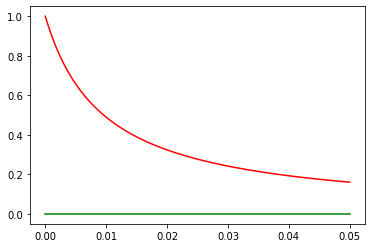

In [3]:
x = np.linspace(0.00,0.05,100)
plt.plot(x, P_B_A(x, 0.05), 'r')
plt.plot(x, P_B_notA(x, 0.05), 'g')
plt.show()

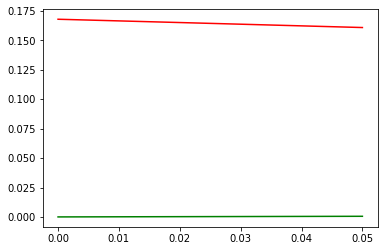

In [4]:
x = np.linspace(0.00,0.05,100)
plt.plot(x, P_B_A(0.05, x),'r')
plt.plot(x, P_B_notA(0.05, x), 'g')
plt.show()

Исходя из двух полученных выше графиков, можно сделать вывод, что стоит уменьшать false positive ошибку, при уменьшении которой растет вероятность $P(B|A)$, но не увеличивает $P(B|\overline{A})$.

Часть II

In [5]:
dataset = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")

In [6]:
dataset = dataset[(dataset['location'] == "Russia") & (dataset['date'] >= '2020-03-03')]

In [7]:
x = np.array(range(1,51)).reshape(-1,1)
y_total = np.array(np.log(dataset.head(50).total_cases)).reshape(-1,1)
y_new = np.array(np.log(np.where(dataset.head(50).new_cases==0, 1, dataset.head(50).new_cases))).reshape(-1,1)

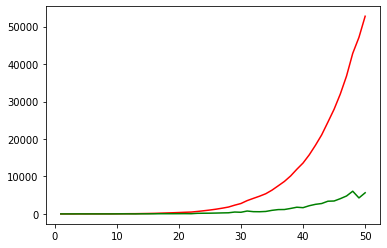

In [8]:
plt.plot(x,dataset.head(50).total_cases,'r')
plt.plot(x,dataset.head(50).new_cases,'g')
plt.show()

In [66]:
model_total = LinearRegression().fit(x, y_total)
print(model_total.coef_[0], ' ', model_total.intercept_[0])
model_new = LinearRegression().fit(x, y_new)
print(model_new.coef_[0], ' ', model_new.intercept_[0])

[0.19829091]   1.62244623644881
[0.18596309]   0.13472442721454136


In [9]:
def get_P_D_w(x, y, w): #get P(D|w)
  y_prac = y
  y_theor = w[0]*x + w[1]
  noise = y_prac - y_theor
  sigma2 = (noise**2).mean() - (noise.mean())**2
  P_D_w = np.exp((-50/2)*np.log(2*3.14*sigma2) - (noise**2).sum()/(2*sigma2)) #P(D|w)
  return P_D_w

In [10]:
def get_linreg(x,y):
  model = LinearRegression()
  model.fit(x, y)
  return model

In [11]:
model = LinearRegression()
coefs = []
intercepts = []
for i in range(1000):
  choice = np.random.choice(np.arange(40), size=40, replace=True)
  model.fit(x[choice], y_total[choice])
  coefs.append(model.coef_[0])
  intercepts.append(model.intercept_[0])
hist_c, bin_c = np.histogram(coefs, bins=100)
hist_i, bin_i = np.histogram(intercepts, bins=100)#для total cases

In [12]:
def get_P_w(x, y, w): #P(w)
  ind_c = np.digitize(w[0], bin_c)
  ind_i = np.digitize(w[1], bin_i)
  if ind_c < 100 and ind_i < 100:
    return hist_c[ind_c-1] * hist_i[ind_i-1] / 10000
  else:
    return 0

In [39]:
def get_P_w_D(x,y,w,C,I): #P(w|D)
  P_D = 0
  for c in C:
    for i in I:
      P_D += get_P_D_w(x,y,[c,i]) * get_P_w(x,y,[c,i])
  return get_P_D_w(x,y,w) * get_P_w(x,y,w) / P_D

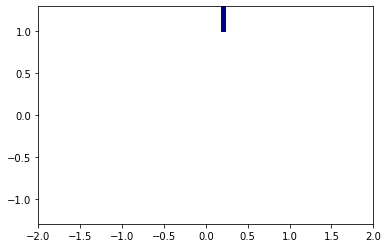

In [34]:
Z = np.array([[get_P_w_D(x,y_total,[c,i], np.arange(0.19,0.24,0.001),np.arange(1.0,2.0,0.01)) for c in np.arange(0.19,0.24,0.001)] for i in np.arange(1.0,2.0,0.01)])

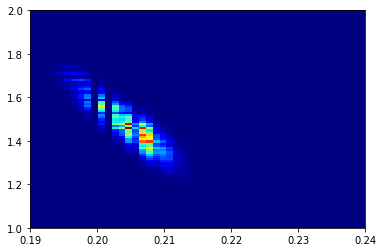

In [38]:
X = np.linspace(0.19, 0.24, 50)
Y = np.linspace(1, 2, 100)
X, Y = np.meshgrid(X, Y)
plt.xlim((0.19, 0.24))
plt.ylim((1, 2))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet) #апостериорное распределение для параметров модели при целевой cases_total, по х coef_, по y intercepts_

In [43]:
model = LinearRegression()
coefs = []
intercepts = []
for i in range(1000):
  choice = np.random.choice(np.arange(40), size=40, replace=True)
  model.fit(x[choice], y_new[choice])
  coefs.append(model.coef_[0])
  intercepts.append(model.intercept_[0])
hist_c, bin_c = np.histogram(coefs, bins=100)
hist_i, bin_i = np.histogram(intercepts, bins=100)#для new cases

In [63]:
Z = np.array([[get_P_w_D(x,y_new,[c,i], np.arange(0.17,0.24,0.005),np.arange(-0.9,0.9,0.05)) for c in np.arange(0.17,0.24,0.005)] for i in np.arange(-0.9,0.9,0.05)])

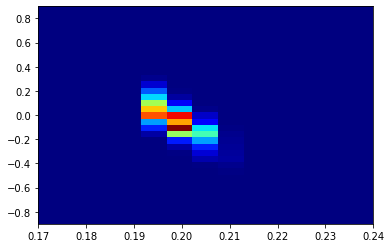

In [65]:
X = np.linspace(0.17, 0.24, 14)
Y = np.linspace(-0.9, 0.9, 36)
X, Y = np.meshgrid(X, Y)
plt.xlim((0.17, 0.24))
plt.ylim((-0.9, 0.9))
plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet) #апостериорное распределение для параметров модели при целевой new_total, по х coef_, по y intercepts_

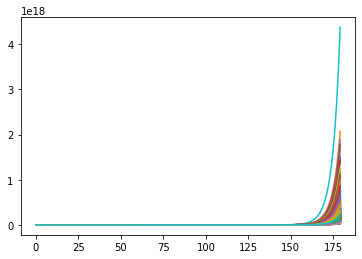

In [68]:
model = LinearRegression()
coefs = []
intercepts = []
x_test = np.arange(180).reshape(-1,1)
for i in range(1000):
  choice = np.random.choice(np.arange(40), size=40, replace=True)
  model.fit(x[choice], y_total[choice])
  y_pred=np.exp(model.predict(x_test))
  plt.plot(x_test,y_pred)
plt.show() #график всего случаев за 180 дней

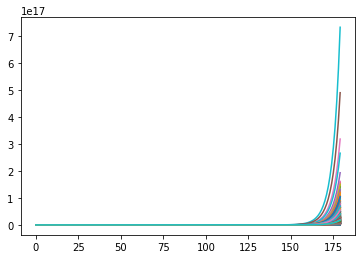

In [69]:
model = LinearRegression()
coefs = []
intercepts = []
x_test = np.arange(180).reshape(-1,1)
for i in range(1000):
  choice = np.random.choice(np.arange(40), size=40, replace=True)
  model.fit(x[choice], y_new[choice])
  y_pred=np.exp(model.predict(x_test))
  plt.plot(x_test,y_pred)
plt.show() #график новых случаев за 180 дней